In [1]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
import numpy as np
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict

[nltk_data] Downloading package stopwords to /home/dias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Hashing

In [2]:
file_read = open("/home/dias/Downloads/hash.txt",'r')
read=file_read.readlines()
file_read.close()

In [3]:
#lets count how many rows we have
len(read)

139000000

In [4]:
'''
We tried to read all the rows but even reading 100 million breaks our pcs.
So we decided to read first 50 million to show you that script is working.
'''
read1=read[:50000000]

In [5]:
#In this function , passing array having hash keys and Creating buckting here.
def HLLog(input_log):
    np_data = -1*np.ones(10000)
    for i in range (len(input_log)):
        [k,v]=Hash_bucket(input_log[i])
        if (v > np_data[k]):
            np_data[k]=v
    bh=np_data[np_data != -1]
    summ=sum(bh)
    len_n=len(bh)
    return(summ,len_n)



#This function is getting input data in parts and according to mentioned bucket, it is return key and value
def Hash_bucket(input_data):
    size=5
    s=str(bin(int((input_data.replace('\n','')),16))).replace('0b','')
    hk=s[:size]
    k=int(hk, 2) 
    z=s[size:]
    s=0
    cnt=0
    while(cnt<(len(z)-1) and s==0 ):
        if(z[cnt]!='0'):
            s=1
        if(z[cnt]=='0'):
            cnt=cnt+1
        
    return (k,cnt)



# In this function, I am dividing the data into subparts and passing them to hash function for getting cardinatlity and error.
def main_func(input_data):
    print(input_data) 
    alg=int(len(input_data)/1000)
    print(alg)
    s=0
    n=0
    for k in range (1000):
        [i,j]=HLLog(input_data[k*alg:(k+1)*alg])
        s=s+i
        #print(n)
        #print(s)
        n=n+j
        print(n)
        print(j)
        cardinality=n*(2**(s/n))
        error=(1.3/math.sqrt(n))*100
        print("Cardinality:",0.7*(int(cardinality)))
        print("err:", error)
        return (0.7*cardinality,error)

In [6]:
[cardinality,error] =  main_func(read1)

In [8]:
cardinality

26121.078188595086

In [7]:
error

32.5

## 2. Clustering

In [2]:
#read file
df = pd.read_csv('/home/dias/Desktop/HW/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
a= df['Text']
a

0         I have bought several of the Vitality canned d...
1         Product arrived labeled as Jumbo Salted Peanut...
2         This is a confection that has been around a fe...
3         If you are looking for the secret ingredient i...
4         Great taffy at a great price.  There was a wid...
                                ...                        
568449    Great for sesame chicken..this is a good if no...
568450    I'm disappointed with the flavor. The chocolat...
568451    These stars are small, so you can give 10-15 o...
568452    These are the BEST treats for training and rew...
568453    I am very satisfied ,product is as advertised,...
Name: Text, Length: 568454, dtype: object

In [4]:
def preprocess(data):
    #removing all nonalphabetical symbols
    x=re.sub('[^a-zA-Z]', ' ',data) 
    
    #lowering words
    lower=str.lower(x).split() 
    words=set(stopwords.words('english'))
    
    #removing stopwords
    no_stopwords=[w for w in lower if not w in words]  
    lmtzr = WordNetLemmatizer()
    ps = PorterStemmer()
    #stemming or lemmatizing
    cleaned=[lmtzr.lemmatize(w) for w in no_stopwords] 
    
    
    return (" ".join( cleaned ))

In [5]:
df['clean_text'] = df.apply(lambda x: preprocess(x['Text']),axis = 1)

In [6]:
df['clean_text']

0         bought several vitality canned dog food produc...
1         product arrived labeled jumbo salted peanut pe...
2         confection around century light pillowy citrus...
3         looking secret ingredient robitussin believe f...
4         great taffy great price wide assortment yummy ...
                                ...                        
568449    great sesame chicken good better resturants ea...
568450    disappointed flavor chocolate note especially ...
568451    star small give one training session tried tra...
568452    best treat training rewarding dog good groomin...
568453    satisfied product advertised use cereal raw vi...
Name: clean_text, Length: 568454, dtype: object

In [7]:
#vectorizing the words with tfidf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
X

<568454x102634 sparse matrix of type '<class 'numpy.float64'>'
	with 18727587 stored elements in Compressed Sparse Row format>

In [15]:
print(vectorizer.get_feature_names())

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaacccccccckkkkkk', 'aaaaaaaaagghh', 'aaaaaaah', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaah', 'aaaaaahhh', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhyaaaaaa', 'aaaaaand', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaaallll', 'aaaaawsome', 'aaaah', 'aaaahhhhhh', 'aaaahhhhhhhhhhh', 'aaaallll', 'aaaand', 'aaaannnnddd', 'aaaarrrrghh', 'aaagh', 'aaah', 'aaahhh', 'aaahhhhhh', 'aaahhhs', 'aaahs', 'aabout', 'aabsolutely', 'aachen', 'aachener', 'aacurate', 'aacute', 'aad', 'aadd', 'aadmit', 'aadp', 'aadults', 'aaf', 'aafco', 'aafes', 'aafter', 'aagh', 'aah', 'aahhed', 'aahhhs', 'aahing', 'aahs', 'aain', 'aakaufman', 'aalmost', 'aaloo', 'aamazon', 'aamzon', 'aana', 'aand', 'aanfq', 'aanother', 'aany', 'aap', 'aappublications', 'aardvark', 'aare', 'aarg

In [16]:
from tqdm import tqdm
corpus = []
for word in tqdm(df['clean_text']):
    corpus.append(word.split())

corpus[:5]
# count words
counter = {}
for sent in tqdm(corpus):
    for word in sent:
        counter[word] = counter.get(word, 0) + 1

100%|██████████| 568454/568454 [00:04<00:00, 127835.74it/s]


Text(0, 0.5, 'log(frequency)')

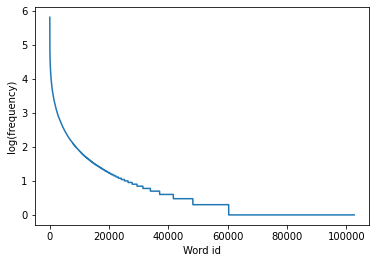

In [17]:
'''Graph of word frequency with stemming'''
plt.plot(sorted([np.log10(v) for v in counter.values()], reverse=True))
plt.xlabel('Word id')
plt.ylabel('log(frequency)')

Text(0, 0.5, 'log(frequency)')

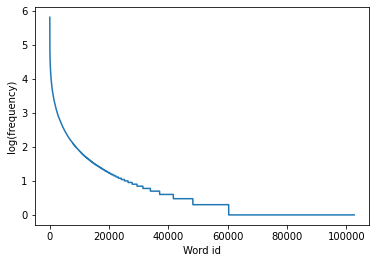

In [18]:
'''Graph of word frequency with lemmatizing'''
plt.plot(sorted([np.log10(v) for v in counter.values()], reverse=True))
plt.xlabel('Word id')
plt.ylabel('log(frequency)')

### lemmatizing is better as number of words with low frequency is much lower 

In [8]:
X.shape

(568454, 102634)

In [9]:
n_components = 1200
svd = TruncatedSVD(n_components=n_components, random_state = 0)
X_2d = svd.fit_transform(X)

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

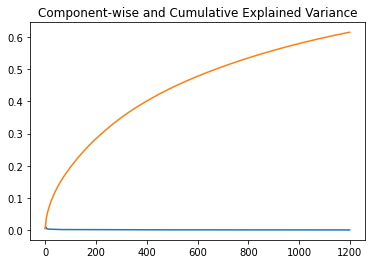

In [10]:
plt.plot(range(n_components), svd.explained_variance_ratio_)
plt.plot(range(n_components), np.cumsum(svd.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

#### As we can see 1200 components are enough to cover 60% of variance 

## K-means

## K-means++

In [30]:
from sklearn import metrics 
from scipy.spatial.distance import cdist 
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
for k in range(1,11): 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X_2d) 
    kmeanModel.fit(X_2d)     
      
    distortions.append(sum(np.min(cdist(X_2d, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X_2d.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X_2d, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X_2d.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

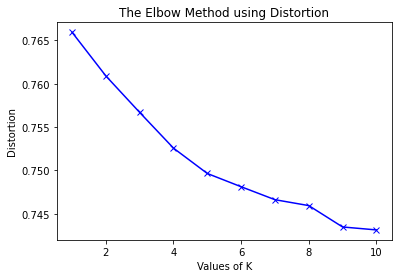

In [32]:
plt.plot(range(1,11), distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 
#We decided to use 10 clusters

In [14]:
model = KMeans(n_clusters = 10,init='k-means++', random_state=99)
model.fit(X_2d)

KMeans(n_clusters=10, random_state=99)

In [15]:
labels = model.labels_
cluster_center=model.cluster_centers_

In [22]:
df['cluster']=labels
df_cluster = df.groupby('cluster')['clean_text'].apply(lambda x: ' '.join(x)).reset_index()
df_cluster.cluster += 1

In [23]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_text,cluster
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,8
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...,9
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,0


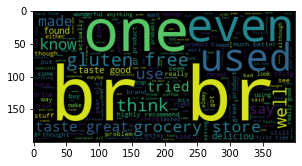

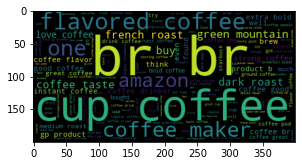

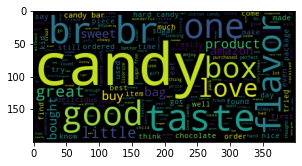

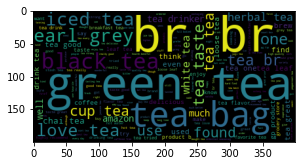

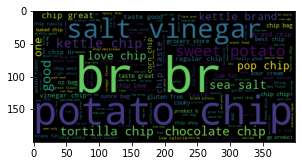

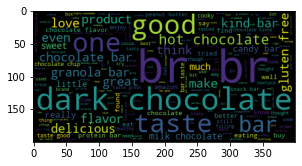

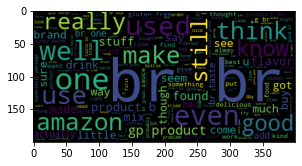

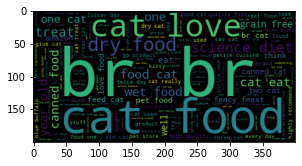

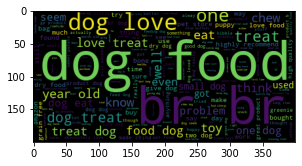

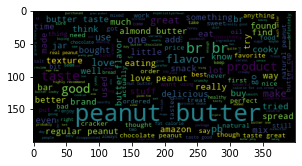

In [25]:
for i in range(len(df_cluster)):
    wordcloud = WordCloud().generate(df_cluster.iloc[i].clean_text) 
    plt.figure(figsize = (4,4)) 
    plt.imshow(wordcloud) 
    plt.tight_layout(pad = 0) 
    plt.show()

In [ ]:
'''
According to worclouds here's what we think the clusters are:   
1. prothinking
2. coffee
3. sweet,tasty
4. tea
5. chip?
6. chocolate
7. positive review
8. cat food
9. dog food
10. peanut butter
'''

In [26]:
#number of products in each cluster
df.groupby('cluster')['ProductId'].count()

cluster
0    310936
1     51315
2      9041
3     36210
4     14397
5     22384
6     61309
7     17321
8     38080
9      7461
Name: ProductId, dtype: int64

In [27]:
#number of unique users writing reviews in each cluster
df.groupby('cluster')['UserId'].nunique()

cluster
0    171915
1     24053
2      7477
3     19384
4      4126
5     12418
6     28644
7      6764
8     15379
9      4889
Name: UserId, dtype: int64

## 3. Algorithmic question.

You are given an array with A with n integer numbers.

    Let s = min{ A[1], ..., A[n] } and b = max { A[1], ..., A[n] }.
    Let r = b - s

Prove that we can sort A in time O(n + r).

### Our solution 
To count number of occurences (x) of every element in array A, then put every element in order in final array x times, so the time complexity will be O(n+k), where n is the length and k is the number of distinct elements in A.

In [1]:
'''For example:'''
A=[11,5,3,1]

s=1 #min

b=11 #max
r=b-s 

n=len(A)
k=len(count)


count = defaultdict(int)

#count occurences
for i in A:
    count[i] += 1
    
count

defaultdict(int, {11: 1, 5: 1, 3: 1, 1: 1})

In [2]:
result = []

#put them in final array
for j in range(s,b+1):
    result += [j]* count[j]

result

[1, 3, 5, 11]

In the worst case the algorithm will take time O(n+n) times as in A there can be all distinct numbers. 
And the shortest time for the problem can be O(n+n-1) when all the numbers are distinct and non-negative, which is equal to O(n+n).
It proves that it is possible to sort A in time O(n + r).

For those who did not understand why shortest time for the problem is O(n+n-1):
    
Imagine we have A = [5,3,4,2,1]

r= 4
n=5
r =n-1

Then we have B = [5,3,2,1]

r=n

Then we have C= [5,5,3,2,3,2,1]

r= n+3

and so on